In [13]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir src
  !cp -r drive/MyDrive/IFT780/HappyWhale/src/* src/
  !mkdir data
  !cp -r drive/MyDrive/IFT780/HappyWhale/data/* data/
  IN_COLAB = True
  #!pip install timm
except:
  IN_COLAB = False
  #%pip install -r requirements.txt

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HappyWhale Challenge - Team WhalePlayed

This notebook presents the work done by Gaétan Rey, Julien Levarlet and Timothée Wright, as part of the challenge https://www.kaggle.com/competitions/happy-whale-and-dolphin/overview .

Imports :

In [14]:
import torch.nn as nn
import torch
from src.ModelTrainTestManager import ModelTrainTestManager, optimizer_setup
from src.DataManager import DataManager
from src.Models.ResNet import ResNet
from src.Models.HappyWhaleModel import HappyWhaleModel

torch.cuda.empty_cache()

Parameters for the data :

In [15]:
data_csv = "data/five.csv"
dataFolderPath = "data/five_class"

Parameters for the training :

In [16]:
batch_size = 10
learning_rate = 0.01
optimizer_factory = optimizer_setup(torch.optim.Adam, lr=learning_rate)

test_percentage = 0.2
val_percentage = 0.2

exp_name = "HappyWhale"

Parameters for the model :

In [17]:
num_classes=20
in_channels=3
depth=3
option="small"
size=128

# ArcFace Hyperparameters
arcFace_config = {
    "s": 30.0,  # scale (The scale parameter changes the shape of the logits. The higher the scale, the more peaky the logits vector becomes.)
    "m": 0.50,  # margin (margin results in a bigger separation of classes in your training set)
    "ls_eps": 0.0,
    "easy_margin": False
}

#model = HappyWhaleModel("tf_efficientnet_b0_ns", 512, num_class=20, arcface_config=arcFace_config)
model = ResNet(num_classes, in_channels, depth, option, size)

In [18]:
data_manager = DataManager(data_csv, dataFolderPath, batch_size,
                test_percentage, val_percentage, verbose=True)

model_trainer = ModelTrainTestManager(model=model,
                                        data_manager = data_manager,
                                        loss_fn=nn.CrossEntropyLoss(),
                                        optimizer_factory=optimizer_factory,
                                        exp_name = exp_name ,
                                        learning_rate=learning_rate,
                                        use_cuda=True)

                image  individual_id
0  001001f099519f.jpg              1
1  0024057bbc89a4.jpg              0
2  0046ceef89b3fc.jpg              2
3  005e53b1b6aada.jpg              2
4  0106d276033b78.jpg              2
Dataset size : 730
Size of validation set : 117
Size of test set : 146
Size of train set : 467


In [19]:
epoch=20
model_trainer.train(epoch)

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 1 of 20


  0%|          | 0/47 [00:04<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x65536 and 262144x20)

Accuracy on the test set: 0.000 %


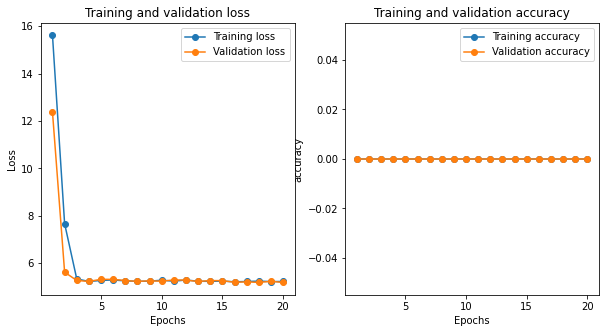

In [ ]:
model_trainer.evaluate_on_test_set()
model_trainer.plot_metrics(exp_name)

In [ ]:
from src.HyperparameterSearch import HyperparameterSearchManager

params = {
    "learning_rate": [0.1,0.01,0.001],
    "arcface_s": [20,30.0,40],
    "arcface_m": [0.4,0.5,0.6],
}

hs = HyperparameterSearchManager(HappyWhaleModel,
                params=params,
                data_manager = data_manager,
                loss_fn=nn.CrossEntropyLoss(),
                optimizer_factory=optimizer_factory,
                exp_name="hyperparameter_search",
                num_epoch=3,)

print(hs.get_best_param())

Parameters : lr 0.1 , s 20 , m 0.4


100%|██████████| 47/47 [00:14<00:00,  3.15it/s, loss=3.147]


Finished training.
Validation loss : 3.112608551979065 , validation accuracy : 0.0
Parameters : lr 0.1 , s 20 , m 0.5


 70%|███████   | 33/47 [00:10<00:04,  3.05it/s, loss=6.031]


KeyboardInterrupt: 

Accuracy on the test set: 0.000 %


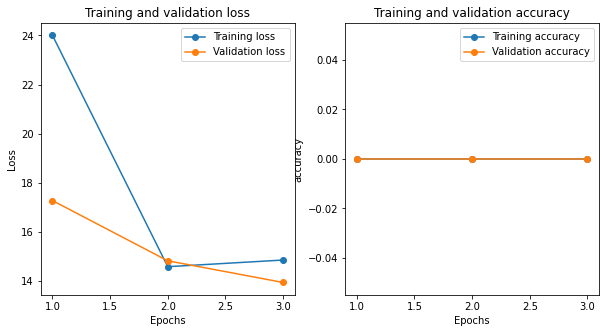

In [ ]:
model = hs.get_best_model()
hs.evaluate_best_on_test_set()
model.save(exp_name)